In [1]:
#region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from statistics import mean
from sklearn.model_selection import KFold   
import joblib 
#endregion


In [3]:
# In[2]: PART 2. GET THE DATA (DONE). LOAD DATA
raw_data = pd.read_csv('datasets\GiaChungCu_HCM_June2021_laydulieu_com.csv')



# In[3]: PART 3. DISCOVER THE DATA TO GAIN INSIGHTS
#region
# 3.1 Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())              



____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GIỐNG - LOẠI        1950 non-null   object 
 1   GIỐNG - NHU CẦU     1950 non-null   object 
 2   GIỐNG - TỈNH THÀNH  1950 non-null   object 
 3   QUẬN HUYỆN          1950 non-null   object 
 4   GIÁ - TRIỆU ĐỒNG    1950 non-null   float64
 5   DIỆN TÍCH - M2      1948 non-null   float64
 6   HƯỚNG               658 non-null    object 
 7   SỐ TẦNG             0 non-null      float64
 8   SỐ PHÒNG            1945 non-null   float64
 9   SỐ TOILETS          1895 non-null   float64
 10  GIẤY TỜ PHÁP LÝ     1462 non-null   object 
dtypes: float64(5), object(6)
memory usage: 167.7+ KB
None


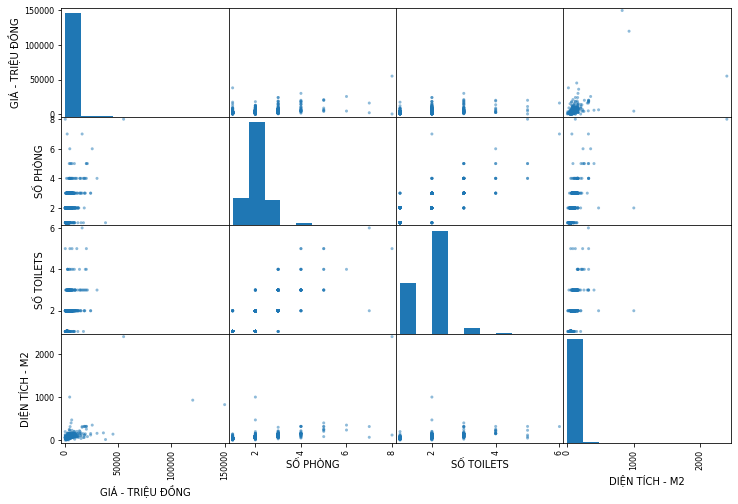

In [4]:
from pandas.plotting import scatter_matrix   
features_to_plot = ["GIÁ - TRIỆU ĐỒNG", "SỐ PHÒNG", "SỐ TOILETS", "DIỆN TÍCH - M2"]
scatter_matrix(raw_data[features_to_plot], figsize=(12, 8)) # Note: histograms on the main diagonal
plt.savefig('figures/scatter_mat_all_feat.png', format='png', dpi=300)
plt.show()

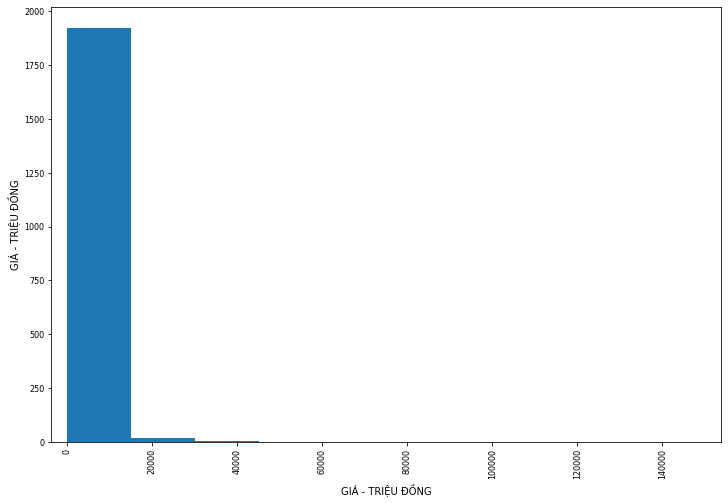

In [43]:
from pandas.plotting import scatter_matrix   
features_to_plot = ["GIÁ - TRIỆU ĐỒNG"]
scatter_matrix(raw_data[features_to_plot], figsize=(12, 8)) # Note: histograms on the main diagonal
plt.show()

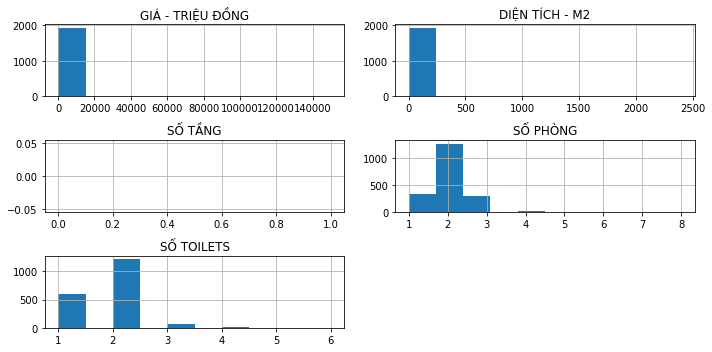

In [44]:
raw_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.tight_layout()
plt.savefig('code_week3/figures/hist_raw_data.png', format='png', dpi=300) # must save before show()
plt.show()

In [45]:
# 3.6 Compute correlations b/w features
corr_matrix = raw_data.corr()
print(corr_matrix) # print correlation matrix
print('\n',corr_matrix["GIÁ - TRIỆU ĐỒNG"].sort_values(ascending=False)) # print correlation b/w a feature and other features


                  GIÁ - TRIỆU ĐỒNG  DIỆN TÍCH - M2  SỐ TẦNG  SỐ PHÒNG  \
GIÁ - TRIỆU ĐỒNG          1.000000        0.602767      NaN  0.442182   
DIỆN TÍCH - M2            0.602767        1.000000      NaN  0.491807   
SỐ TẦNG                        NaN             NaN      NaN       NaN   
SỐ PHÒNG                  0.442182        0.491807      NaN  1.000000   
SỐ TOILETS                0.395878        0.519317      NaN  0.686101   

                  SỐ TOILETS  
GIÁ - TRIỆU ĐỒNG    0.395878  
DIỆN TÍCH - M2      0.519317  
SỐ TẦNG                  NaN  
SỐ PHÒNG            0.686101  
SỐ TOILETS          1.000000  

 GIÁ - TRIỆU ĐỒNG    1.000000
DIỆN TÍCH - M2      0.602767
SỐ PHÒNG            0.442182
SỐ TOILETS          0.395878
SỐ TẦNG                  NaN
Name: GIÁ - TRIỆU ĐỒNG, dtype: float64


In [46]:
# 3.7 Try combining features
raw_data["DIỆN TÍCH PHÒNG"] = raw_data["DIỆN TÍCH - M2"] / raw_data["SỐ PHÒNG"] 
raw_data["TỔNG SỐ PHÒNG"] = raw_data["SỐ PHÒNG"] + raw_data["SỐ TOILETS"] 
corr_matrix = raw_data.corr()
print(corr_matrix["GIÁ - TRIỆU ĐỒNG"].sort_values(ascending=False)) # print correlation b/w a feature and other features
raw_data.drop(columns = ["DIỆN TÍCH PHÒNG", "TỔNG SỐ PHÒNG"], inplace=True) # remove experiment columns
#endregion

GIÁ - TRIỆU ĐỒNG    1.000000
DIỆN TÍCH - M2      0.602767
TỔNG SỐ PHÒNG       0.450769
SỐ PHÒNG            0.442182
SỐ TOILETS          0.395878
DIỆN TÍCH PHÒNG     0.327590
SỐ TẦNG                  NaN
Name: GIÁ - TRIỆU ĐỒNG, dtype: float64


In [47]:
# 4.1 Remove unused features
raw_data.drop(columns = ["GIỐNG - LOẠI", "GIỐNG - NHU CẦU", "GIỐNG - TỈNH THÀNH", "SỐ TẦNG"], inplace=True) 

In [48]:
raw_data["KHOẢNG GIÁ"] = pd.cut(raw_data["GIÁ - TRIỆU ĐỒNG"],
                                bins=[0, 2000, 4000, 6000, 8000, np.inf],
                                #labels=["<2 tỷ", "2-4 tỷ", "4-6 tỷ", "6-8 tỷ", "8-10 tỷ", ">10 tỷ"])
                                labels=[2,4,6,8,100]) # use numeric labels to plot histogram

# Create training and test set
from sklearn.model_selection import StratifiedShuffleSplit  
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # n_splits: no. of re-shuffling & splitting = no. of train-test sets 
                                                                              # (if you want to run the algorithm n_splits times with different train-test set)
for train_index, test_index in splitter.split(raw_data, raw_data["KHOẢNG GIÁ"]): # Feature "KHOẢNG GIÁ" must NOT contain NaN
    train_set = raw_data.loc[train_index]
    test_set = raw_data.loc[test_index]   

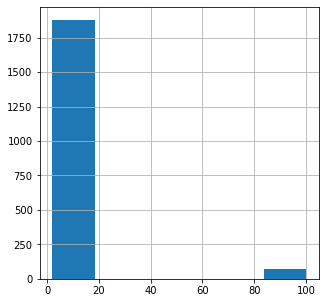

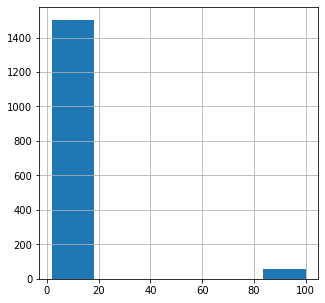

In [49]:
raw_data["KHOẢNG GIÁ"].hist(bins=6, figsize=(5,5)); plt.show();
train_set["KHOẢNG GIÁ"].hist(bins=6, figsize=(5,5)); plt.show()

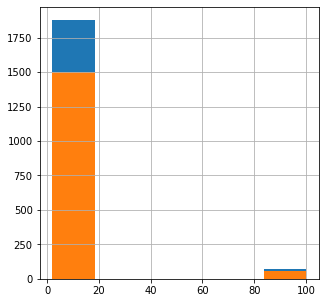

In [50]:
raw_data["KHOẢNG GIÁ"].hist(bins=6, figsize=(5,5));
train_set["KHOẢNG GIÁ"].hist(bins=6, figsize=(5,5)); plt.show()

In [53]:
print(train_set.info())
for _set_ in (train_set, test_set):
  #_set_.drop("income_cat", axis=1, inplace=True) # axis=1: drop cols, axis=0: drop rows
  _set_.drop(columns="KHOẢNG GIÁ", inplace=True) 
print(train_set.info())
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 1516 to 1525
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   QUẬN HUYỆN        1560 non-null   object  
 1   GIÁ - TRIỆU ĐỒNG  1560 non-null   float64 
 2   DIỆN TÍCH - M2    1559 non-null   float64 
 3   HƯỚNG             520 non-null    object  
 4   SỐ PHÒNG          1555 non-null   float64 
 5   SỐ TOILETS        1516 non-null   float64 
 6   GIẤY TỜ PHÁP LÝ   1147 non-null   object  
 7   KHOẢNG GIÁ        1560 non-null   category
dtypes: category(1), float64(4), object(3)
memory usage: 99.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 1516 to 1525
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QUẬN HUYỆN        1560 non-null   object 
 1   GIÁ - TRIỆU ĐỒNG  1560 non-null   float64
 2   DIỆN TÍCH - M2    1559 non-null   floa

In [55]:
#%% 4.3 Separate labels from data, since we do not process label values
train_set_labels = train_set["GIÁ - TRIỆU ĐỒNG"].copy()
train_set = train_set.drop(columns = "GIÁ - TRIỆU ĐỒNG") 
test_set_labels = test_set["GIÁ - TRIỆU ĐỒNG"].copy()
test_set = test_set.drop(columns = "GIÁ - TRIỆU ĐỒNG") 


In [56]:
class ColumnSelector(BaseEstimator, TransformerMixin):
  def __init__(self, feature_names):
      self.feature_names = feature_names
  def fit(self, dataframe, labels=None):
      return self
  def transform(self, dataframe):
      return dataframe[self.feature_names].values         

num_feat_names = ['DIỆN TÍCH - M2', 'SỐ PHÒNG', 'SỐ TOILETS'] # =list(train_set.select_dtypes(include=[np.number]))
cat_feat_names = ['QUẬN HUYỆN', 'HƯỚNG', 'GIẤY TỜ PHÁP LÝ'] # =list(train_set.select_dtypes(exclude=[np.number])) 

# 4.4.2 Pipeline for categorical features
cat_pipeline = Pipeline([
  ('selector', ColumnSelector(cat_feat_names)),
  ('imputer', SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = "NO INFO", copy=True)), # complete missing values. copy=False: imputation will be done in-place 
  ('cat_encoder', OneHotEncoder()) # convert categorical data into one-hot vectors
  ])    
trans_feat_values_1 = cat_pipeline.fit_transform(train_set)

In [58]:
# 4.4.3 Define MyFeatureAdder: a transformer for adding features "TỔNG SỐ PHÒNG",...  
class MyFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_TONG_SO_PHONG = True): # MUST NO *args or **kargs
        self.add_TONG_SO_PHONG = add_TONG_SO_PHONG
    def fit(self, feature_values, labels = None):
        return self  # nothing to do here
    def transform(self, feature_values, labels = None):
        if self.add_TONG_SO_PHONG:        
            SO_PHONG_id, SO_TOILETS_id = 1, 2 # column indices in num_feat_names. can't use column names b/c the transformer SimpleImputer removed them
            # NOTE: a transformer in a pipeline ALWAYS return dataframe.values (ie., NO header and row index)
            
            TONG_SO_PHONG = feature_values[:, SO_PHONG_id] + feature_values[:, SO_TOILETS_id]
            feature_values = np.c_[feature_values, TONG_SO_PHONG] #concatenate np arrays
        return feature_values

# 4.4.4 Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median", copy=True)), # copy=False: imputation will be done in-place 
    ('attribs_adder', MyFeatureAdder(add_TONG_SO_PHONG = True)),
    ('std_scaler', StandardScaler(with_mean=True, with_std=True, copy=True)) # Scale features to zero mean and unit variance
    ])  
  
# 4.4.5 Combine features transformed by two above pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline) ])  


In [59]:
processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2],:].toarray())
print(processed_train_set_val.shape)
print('We have %d numeric feature + 1 added features + 35 cols of onehotvector for categorical features.' %(len(num_feat_names)))
joblib.dump(full_pipeline, r'code_week3/models/full_pipeline.pkl')


____________ Processed feature values ____________
[[ 0.06050546  1.33649616  0.42152059  1.01788528  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [-0.08171221 -0.06749981  0.42152059  0.16737589  0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.8576197   2.74049212  3.86430659  3.56941344  0.          0.
   1.       

['code_week3/models/full_pipeline.pkl']

In [60]:
onehot_cols = []
for val_list in full_pipeline.transformer_list[1][1].named_steps['cat_encoder'].categories_: 
  onehot_cols = onehot_cols + val_list.tolist()
columns_header = train_set.columns.tolist() + ["TỔNG SỐ PHÒNG"] + onehot_cols
for name in cat_feat_names:
  columns_header.remove(name)
processed_train_set = pd.DataFrame(processed_train_set_val.toarray(), columns = columns_header)
print('\n____________ Processed dataframe ____________')
print(processed_train_set.info())
print(processed_train_set.head())


____________ Processed dataframe ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DIỆN TÍCH - M2    1560 non-null   float64
 1   SỐ PHÒNG          1560 non-null   float64
 2   SỐ TOILETS        1560 non-null   float64
 3   TỔNG SỐ PHÒNG     1560 non-null   float64
 4   Huyện Bình Chánh  1560 non-null   float64
 5   Huyện Hóc Môn     1560 non-null   float64
 6   Huyện Nhà Bè      1560 non-null   float64
 7   Quận 1            1560 non-null   float64
 8   Quận 10           1560 non-null   float64
 9   Quận 11           1560 non-null   float64
 10  Quận 12           1560 non-null   float64
 11  Quận 2            1560 non-null   float64
 12  Quận 3            1560 non-null   float64
 13  Quận 4            1560 non-null   float64
 14  Quận 5            1560 non-null   float64
 15  Quận 6            1560 non-null   float64
